<a href="https://colab.research.google.com/github/joeyuy/Climate-Change/blob/main/Climate_Change_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

##### $\rightarrow$ This notebook will investigate rising sea surface temperatures using data from the ERA5 [Reanalysis project](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview). Fourier transforms and spectral analysis are used to identify time-based trends, then these trends are used to forecast sea surface temperatures for the North Atlantic and Indian oceans in future years. Regression is used to find the trends of these forecasts, and give insight into how some countries may be disproportionately affected by climate change than others.

## Import libraries

$\rightarrow$ Import and install necessary libraries for analysis.

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import welch
sns.set_theme(style='whitegrid')

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from itertools import combinations

In [94]:
!pip install pmdarima
!pip install prophet

## Load clean data

$\rightarrow$ Load the clean data set from Github.

In [95]:
df_NAnt = pd.read_csv('https://raw.githubusercontent.com/joeyuy/Climate-Change/main/north_atlantic.csv')
df_Ind = pd.read_csv('https://raw.githubusercontent.com/joeyuy/Climate-Change/main/indian.csv')

##### $\rightarrow$ Review the contents of the data set.

In [96]:
df_NAnt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30745 entries, 0 to 30744
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sst        30745 non-null  float64
 1   u10        30745 non-null  float64
 2   hsig       30745 non-null  float64
 3   time       30745 non-null  object 
 4   latitude   30745 non-null  float64
 5   longitude  30745 non-null  float64
dtypes: float64(5), object(1)
memory usage: 1.4+ MB


In [97]:
df_Ind.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30745 entries, 0 to 30744
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sst        30745 non-null  float64
 1   u10        30745 non-null  float64
 2   hsig       30745 non-null  float64
 3   time       30745 non-null  object 
 4   latitude   30745 non-null  float64
 5   longitude  30745 non-null  float64
dtypes: float64(5), object(1)
memory usage: 1.4+ MB


In [98]:
df_NAnt.head()

,sst,u10,hsig,time,latitude,longitude
0,292.86615,10.328670,4.153670,1940-01-01 12:00:00,35.9,-41.1
1,292.79900,7.875400,3.853531,1940-01-02 12:00:00,35.9,-41.1
2,292.73737,11.206657,3.518368,1940-01-03 12:00:00,35.9,-41.1
3,292.67316,11.615847,4.042061,1940-01-04 12:00:00,35.9,-41.1
4,292.61040,15.107924,5.225357,1940-01-05 12:00:00,35.9,-41.1


## State your questions

The overall problem is to determine how sea surface temperatures are changing over time and the trends that govern these changes. As a further step, it will be interesting to see how if the people responsible for climate change are the ones suffering from it.

Looking at this [database](https://www.worldometers.info/co2-emissions/co2-emissions-per-capita/), it is clear that barring oil-producing countries that rely on the resource for economic wellbeing, North American and Northern European citizens tend to have the biggest contributions to carbon emissions per capita. As such, it will be interesting to see how trends differ from the North Atlantic and Indian oceans. The Indian ocean is compared because the Indonesia is most affected by climate change with their capital city Jakarta gradually falling under sea level. It is also worth looking into the Indian ocean because China and India are the number 1 and 3 aggregate contributors to carbon emissions (albeit mainly due to their large populations).

##### $\rightarrow$ List your questions about the data that will help you solve the problem.

1. What sea surface temperature trends can be identified with spectral analysis?

2. Which trends are shared between oceans and disproportionately affect one ocean over the other?

## Analysis

Perform analyses necessary to answer the questions.

### Spectral Analysis

$\rightarrow$ Transforming data into Fourier series and applying spectral analysis to identify significant trends.

In [99]:
sst_N = df_NAnt["sst"].values
n_N = len(sst_N)  # Total length
t_N = np.arange(n_N)  # Daily data, so the time vector starts at 0 and ends at n - 1
dt_N = t_N[1] - t_N[0]  # Sampling interval dt = 1 day
fs_N = 1 / dt_N  # Sampling frequency fs = 1 sample/day (often abbreviated cpd for cycles per day)
f0_N = (1 / n_N) / dt_N  # Frequency resolution
p_N = int((n_N - 1) / 2)

sst_I = df_Ind["sst"].values
n_I = len(sst_I)
t_I = np.arange(n_I)
dt_I = t_I[1] - t_I[0]
fs_I = 1 / dt_I
f0_I = (1 / n_I) / dt_I
p_I = int((n_I - 1) / 2)

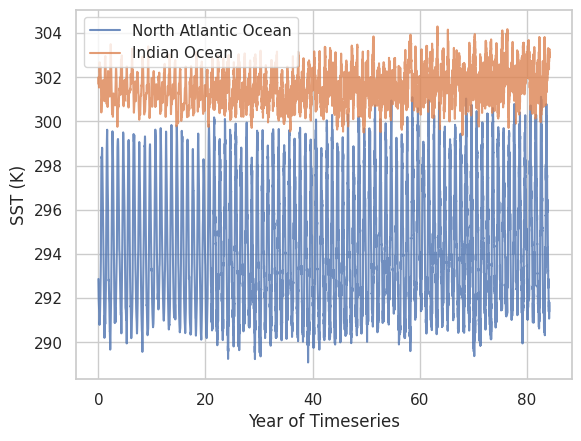

In [100]:
fig, ax = plt.subplots()
ax.plot(t_N / 365, sst_N, alpha=0.8, label="North Atlantic Ocean")
ax.plot(t_I / 365, sst_I, alpha=0.8, label="Indian Ocean")
ax.set_xlabel("Year of Timeseries")
ax.set_ylabel("SST (K)")
ax.legend()

In [101]:
from os import P_PID
frequency_N = np.zeros((p_N + 1,))

for idx, j in enumerate(range(p_N + 1)):
    frequency_N[idx] = f0_N * j

frequency_I = np.zeros((p_I + 1,))

for idx, j in enumerate(range(p_I + 1)):
    frequency_I[idx] = f0_I * j

print(len(frequency_N), len(frequency_I))

15373 15373


#### Finding and isolating spikes in spectromagrams

$\rightarrow$ Start with North Atlantic ocean trends.

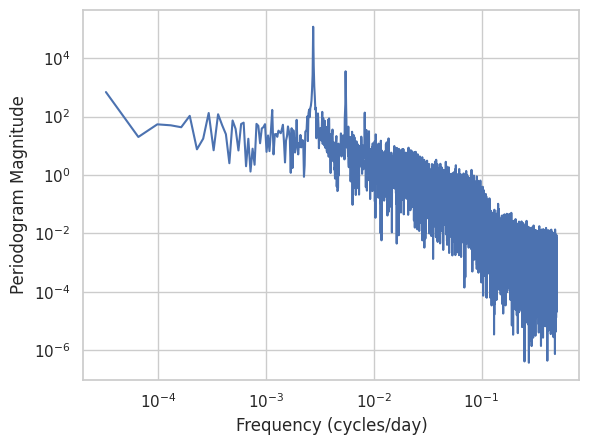

In [102]:
dft_N = np.fft.fft(sst_N)[:p_N + 1]
mag_N = (np.real(dft_N)**2 + np.imag(dft_N)**2) / n_N

fig, ax = plt.subplots()
ax.plot(frequency_N[1:], mag_N[1:])
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("Frequency (cycles/day)")
ax.set_ylabel("Periodogram Magnitude")
plt.show()

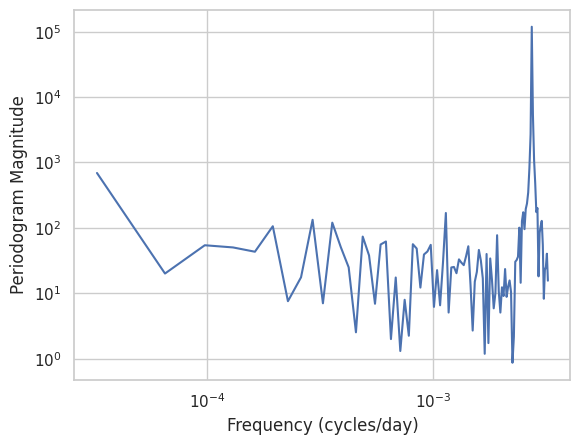

In [103]:
fig, ax = plt.subplots()
ax.plot(frequency_N[1:100], mag_N[1:100])
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("Frequency (cycles/day)")
ax.set_ylabel("Periodogram Magnitude")
plt.show()

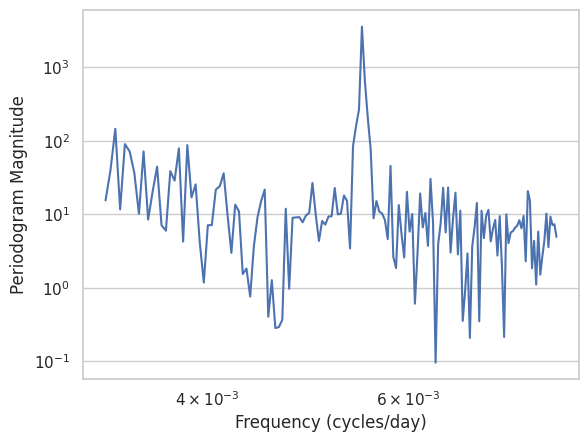

In [104]:
fig, ax = plt.subplots()
ax.plot(frequency_N[100:250], mag_N[100:250])
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("Frequency (cycles/day)")
ax.set_ylabel("Periodogram Magnitude")
plt.show()

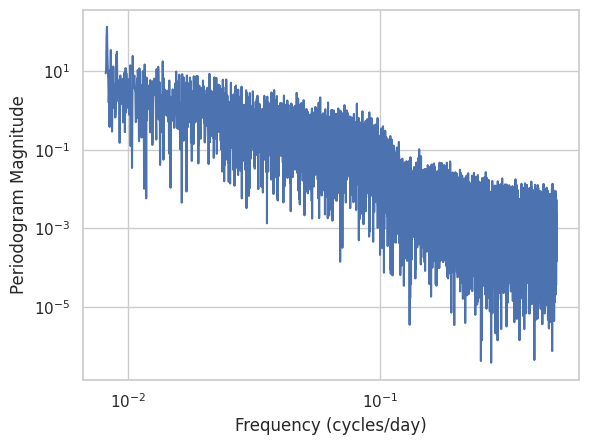

In [105]:
fig, ax = plt.subplots()
ax.plot(frequency_N[250:], mag_N[250:])
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("Frequency (cycles/day)")
ax.set_ylabel("Periodogram Magnitude")
plt.show()

In [106]:
per1_N = 1 / frequency_N[1:][np.argmax(mag_N[1:])]
per2_N = 1 / frequency_N[100:250][np.argmax(mag_N[100:250])]
per3_N = 1 / frequency_N[250:][np.argmax(mag_N[250:])]

m1_N = np.max(mag_N[1:])
m2_N = np.max(mag_N[100:250])
m3_N = np.max(mag_N[250:])

print(per1_N, per2_N, per3_N)
print(m1_N, m2_N, m3_N)

366.01190476190476 183.00595238095238 121.5217391304348
118679.4913474365 3545.083017158222 136.5303599343713


Given our trends have periods of 366, 183, and 121.5 days, it seems like we have an annual trend, a semi-annual trend, 1/3 year trend.

$\rightarrow$ Now find trends for Indian ocean temperature.

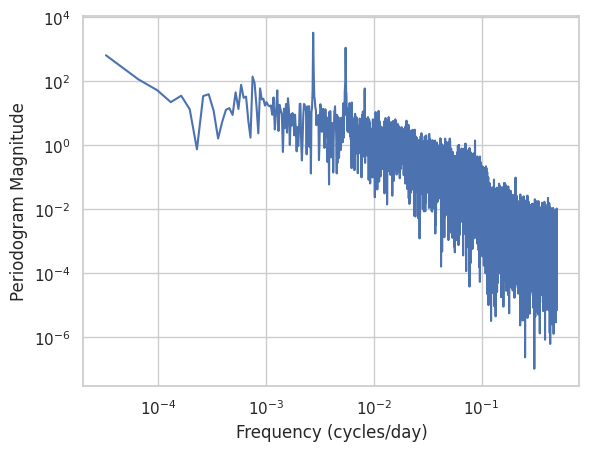

In [107]:
dft_I = np.fft.fft(sst_I)[:p_I + 1]
mag_I = (np.real(dft_I)**2 + np.imag(dft_I)**2) / n_I

fig, ax = plt.subplots()
ax.plot(frequency_I[1:], mag_I[1:])
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("Frequency (cycles/day)")
ax.set_ylabel("Periodogram Magnitude")
plt.show()

It looks like the spikes in the spectromagram are at similar frequencies; let's try the same domain partitioning used for the North Atlantic trends.

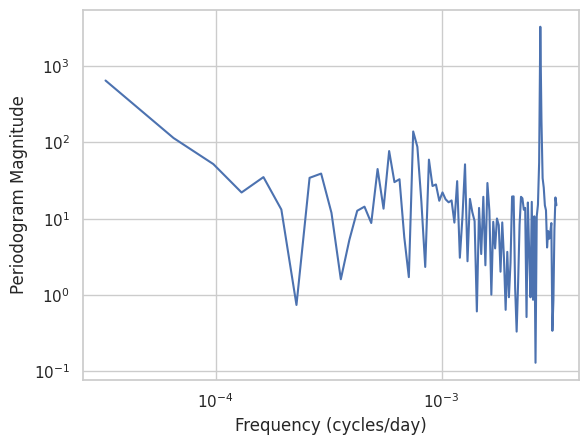

In [108]:
fig, ax = plt.subplots()
ax.plot(frequency_I[1:100], mag_I[1:100])
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("Frequency (cycles/day)")
ax.set_ylabel("Periodogram Magnitude")
plt.show()

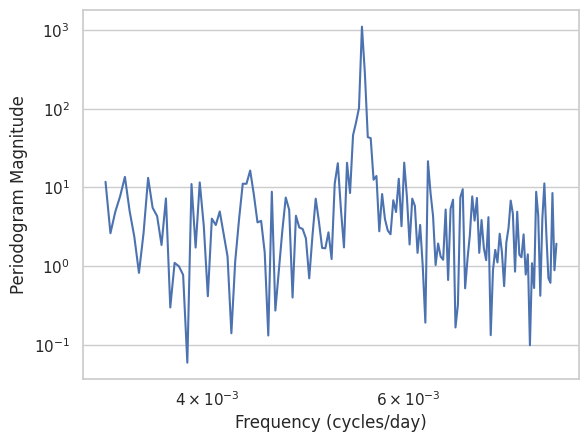

In [109]:
fig, ax = plt.subplots()
ax.plot(frequency_I[100:250], mag_I[100:250])
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("Frequency (cycles/day)")
ax.set_ylabel("Periodogram Magnitude")
plt.show()

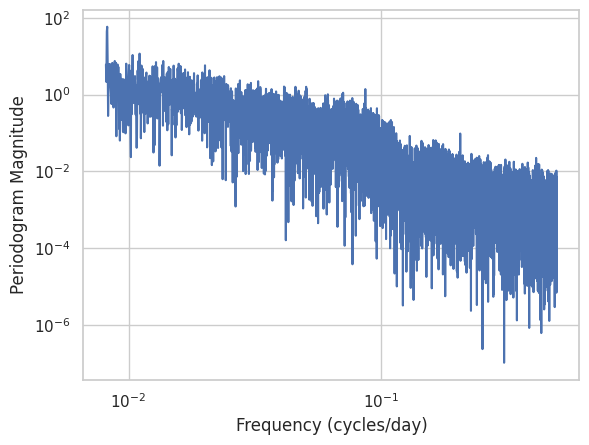

In [110]:
fig, ax = plt.subplots()
ax.plot(frequency_I[250:], mag_I[250:])
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("Frequency (cycles/day)")
ax.set_ylabel("Periodogram Magnitude")
plt.show()

In [111]:
per1_I = 1 / frequency_I[1:][np.argmax(mag_I[1:])]
per2_I = 1 / frequency_I[100:250][np.argmax(mag_I[100:250])]
per3_I = 1 / frequency_I[250:][np.argmax(mag_I[250:])]

m1_I = np.max(mag_I[1:])
m2_I = np.max(mag_I[100:250])
m3_I = np.max(mag_I[250:])

print(per1_I, per2_I, per3_I)
print(m1_I, m2_I, m3_I)

366.01190476190476 183.00595238095238 121.5217391304348
3252.1031639532007 1104.479413198777 58.75679128594228


Looks like the Indian ocean trends have the same periods, but their magnitudes are less pronounced by about 3 times.

### Bandpass filtering

$\rightarrow$ Filtering the data around the frequencies identified in spectral analysis, and constructing a filtered series based on that.

In [112]:
from scipy.signal import butter, filtfilt

In [113]:
t = np.arange(len(sst_N)) #since both oceans have the same date column length, we can use the same dt for all cases
dt = t[1]-t[0]
fs = 1/dt

In [114]:
def bp_filter(sst_ocean,freq):
  fc = freq  # cutoff frequency
  fc_low = fc - 0.001 # Creating a bandpass range around the cutoff frequency
  fc_high = fc + 0.001
  Wn = np.array([fc_low, fc_high]) / (fs / 2)  # critical frequency for butterworth filter
  N = 2  # filter order
  b, a = butter(N, Wn, btype="bandpass")
  yfilt_band = filtfilt(b, a, sst_ocean)

  # fig, ax = plt.subplots()
  # ax.plot(t, sst_ocean, alpha=0.6, label="clean + noise")
  # # ax.plot(t, yclean, linewidth=2, alpha=0.8, label="clean")
  # ax.plot(t, yfilt_band, linewidth=2, label="bandpass filtered")
  # ax.set_xlabel("t")
  # ax.set_ylabel("y")
  # ax.legend()
  # fig.set_size_inches(6, 5)
  # fig.tight_layout(pad=0.5)

  return yfilt_band

In [115]:
f1_N = 1/per1_N
f2_N = 1/per2_N
f3_N = 1/per3_N
f1_I = 1/per1_I
f2_I = 1/per2_I
f3_I = 1/per3_I

In [116]:
print(f1_N, f2_N, f3_N, f1_I, f2_I, f3_I)

0.0027321515693608718 0.0054643031387217435 0.008228980322003577 0.0027321515693608718 0.0054643031387217435 0.008228980322003577


Looks like with a band width of +/- 0.001, there is no overlap. Yay!

In [117]:
signal1_N = bp_filter(sst_N,f1_N)
signal2_N = bp_filter(sst_N,f2_N)
signal3_N = bp_filter(sst_N,f3_N)
a0_N = np.mean(sst_N)

filtered_series_N = signal1_N + signal2_N + signal3_N + a0_N

signal1_I = bp_filter(sst_I,f1_I)
signal2_I = bp_filter(sst_I,f2_I)
signal3_I = bp_filter(sst_I,f3_I)
a0_I = np.mean(sst_I)

filtered_series_I = signal1_I + signal2_I + signal3_I + a0_I

In [118]:
def plot_bp_filter(sst_ocean, yfilt_band):
  fig, ax = plt.subplots()
  ax.plot(t, sst_ocean, alpha=0.6, label="raw data")
  # ax.plot(t, yclean, linewidth=2, alpha=0.8, label="clean")
  ax.plot(t, yfilt_band, linewidth=2, label="bandpass filtered")
  ax.set_xlabel("Time (Days)")
  ax.set_ylabel("Temperature (K)")
  ax.legend()
  fig.set_size_inches(6, 5)
  fig.tight_layout(pad=0.5)

First plot the bandpass filter for the North Atlantic.

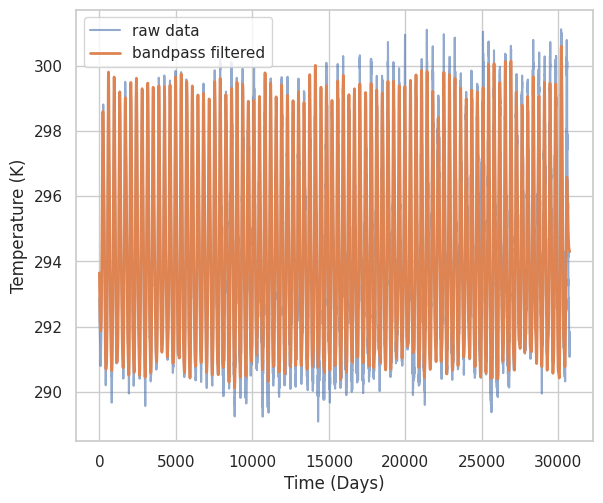

In [119]:
plot_bp_filter(sst_N,filtered_series_N)

And now for the Indian Ocean.

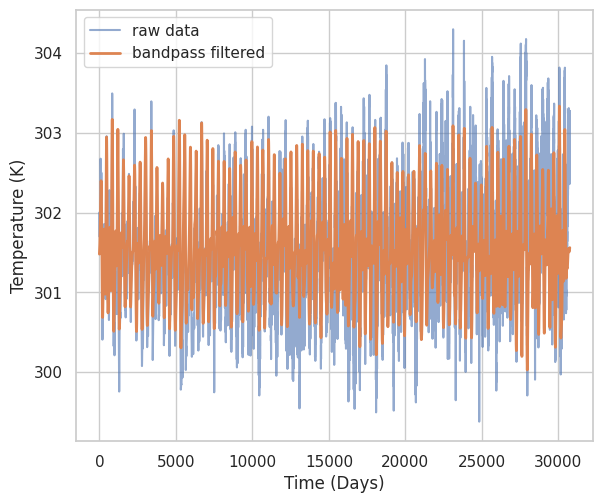

In [120]:
plot_bp_filter(sst_I,filtered_series_I)

The filtered data appears to account for a good amount of the actual data. Nice!

## Forecasting

$\rightarrow$ Using Meta's prophet model to forecast future SST's based on the bandpass-filtered approximate fourier series.

### Train/test split
$\rightarrow$ Splitting the data into training and testing sets in preparation of using the prophet model.

In [121]:
train_indices = list(range(len(df_NAnt) // 2))
test_indices = list(range(len(df_NAnt) // 2, len(df_NAnt)))

N_train = filtered_series_N[train_indices]
N_test = filtered_series_N[test_indices]

time_range_train_N = pd.date_range(start="1940-01-01", periods=len(N_train), freq="D")
time_range_test_N = pd.date_range(start=time_range_train_N[-1] + pd.Timedelta(days=1), periods=len(N_test), freq="D")
df_train_N = pd.DataFrame({"ds": time_range_train_N, "y": N_train.squeeze()})

I_train = filtered_series_I[train_indices]
I_test = filtered_series_I[test_indices]

time_range_train_I = pd.date_range(start="1940-01-01", periods=len(I_train), freq="D")
time_range_test_I = pd.date_range(start=time_range_train_I[-1] + pd.Timedelta(days=1), periods=len(I_test), freq="D")
df_train_I = pd.DataFrame({"ds": time_range_train_I, "y": I_train.squeeze()})

### Prophet Model

$\rightarrow$ Applying the prophet model to create a forecast of SST's.

In [122]:
!pip install prophet
from prophet import Prophet

In [123]:
mN = Prophet()
mN.fit(df_train_N)
future_N = mN.make_future_dataframe(periods=2*len(N_test), freq="D")
forecast_N = mN.predict(future_N)

mI = Prophet()
mI.fit(df_train_I)
future_I = mI.make_future_dataframe(periods=2*len(I_test), freq="D")
forecast_I = mI.predict(future_I)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaov1u9x3/z72ey5e6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaov1u9x3/pha3cr_4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30513', 'data', 'file=/tmp/tmpaov1u9x3/z72ey5e6.json', 'init=/tmp/tmpaov1u9x3/pha3cr_4.json', 'output', 'file=/tmp/tmpaov1u9x3/prophet_model8n4g6d21/prophet_model-20240522185148.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:51:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:51:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpao

### Model Evaluation and Forecasting

$\rightarrow$ Graphing prophet model results and its error relative to the source data.

In [124]:
mae_N = np.nanmean(np.abs(forecast_N.loc[test_indices, "yhat"] - N_test.squeeze()))
mae_I = np.nanmean(np.abs(forecast_I.loc[test_indices, "yhat"] - I_test.squeeze()))

In [125]:
time = np.arange(len(df_NAnt)) #we can use the same time domain for both oceans

In [126]:
future_time = np.arange(train_indices[-1], train_indices[-1] + len(test_indices)*2)

In [127]:
future_indices = list(range(len(future_time)))

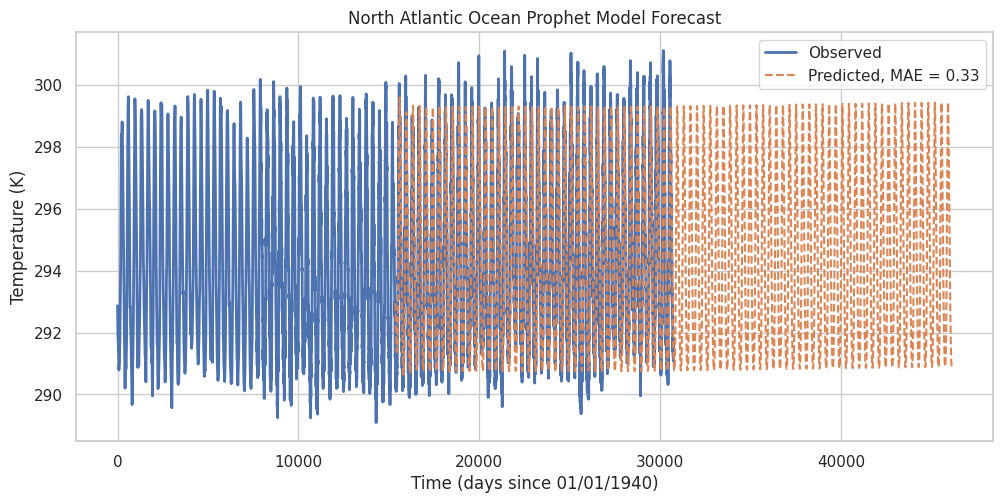

In [128]:
fig, ax = plt.subplots()
ax.plot(time, sst_N, '-', linewidth=2, label="Observed")
ax.plot(future_time, forecast_N.loc[future_indices, "yhat"], '--', label=f"Predicted, MAE = {mae_N:.2f}")
ax.legend()
ax.set_title("North Atlantic Ocean Prophet Model Forecast")
ax.set_xlabel("Time (days since 01/01/1940)")
ax.set_ylabel("Temperature (K)")
fig.set_size_inches(10, 5)
fig.tight_layout(pad=0.5)
plt.show()

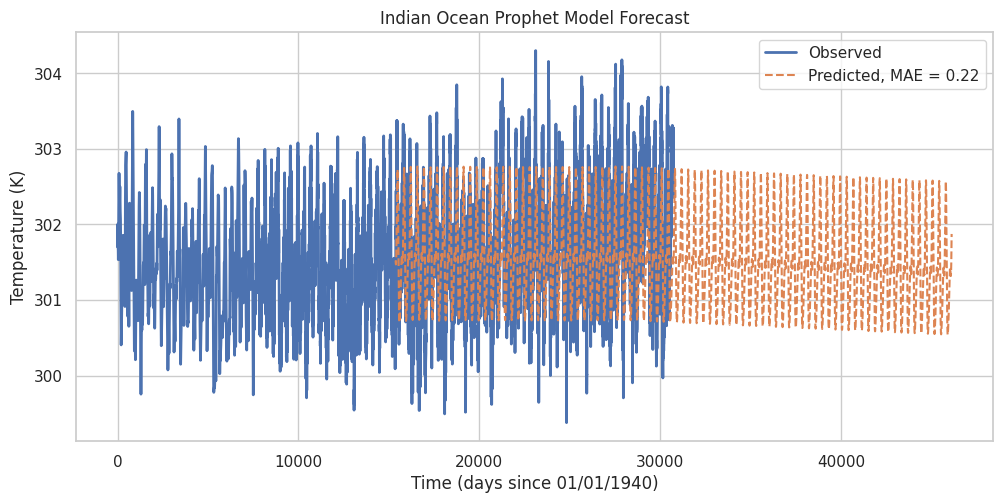

In [129]:
fig, ax = plt.subplots()
ax.plot(time, sst_I, '-', linewidth=2, label="Observed")
ax.plot(future_time, forecast_I.loc[future_indices, "yhat"], '--', label=f"Predicted, MAE = {mae_I:.2f}")
ax.legend()
ax.set_title("Indian Ocean Prophet Model Forecast")
ax.set_xlabel("Time (days since 01/01/1940)")
ax.set_ylabel("Temperature (K)")
fig.set_size_inches(10, 5)
fig.tight_layout(pad=0.5)
plt.show()

## Further Step

$\rightarrow$ Investigating which ocean region is more heavily affected by climate change

### Least squares regression on future projected SST for each ocean.

$\rightarrow$ Using regression to identify the overall movement of future sea surfact temperatures for each ocean, based on prophet model projections.

In [130]:
forecast_N

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1940-01-01,295.046550,292.559487,293.343808,295.046550,295.046550,-2.093021,-2.093021,-2.093021,1.445171e-04,1.445171e-04,1.445171e-04,-2.093166,-2.093166,-2.093166,0.0,0.0,0.0,292.953529
1,1940-01-02,295.044581,292.513246,293.288058,295.044581,295.044581,-2.133981,-2.133981,-2.133981,9.749173e-05,9.749173e-05,9.749173e-05,-2.134079,-2.134079,-2.134079,0.0,0.0,0.0,292.910600
2,1940-01-03,295.042612,292.468683,293.267627,295.042612,295.042612,-2.174480,-2.174480,-2.174480,4.994565e-05,4.994565e-05,4.994565e-05,-2.174530,-2.174530,-2.174530,0.0,0.0,0.0,292.868132
3,1940-01-04,295.040643,292.443545,293.222550,295.040643,295.040643,-2.214519,-2.214519,-2.214519,9.439503e-07,9.439503e-07,9.439503e-07,-2.214520,-2.214520,-2.214520,0.0,0.0,0.0,292.826124
4,1940-01-05,295.038674,292.386401,293.180001,295.038674,295.038674,-2.254097,-2.254097,-2.254097,-4.829132e-05,-4.829132e-05,-4.829132e-05,-2.254048,-2.254048,-2.254048,0.0,0.0,0.0,292.784577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46113,2066-04-02,294.565683,243.477101,339.019981,247.362189,342.410029,-3.406316,-3.406316,-3.406316,-4.829132e-05,-4.829132e-05,-4.829132e-05,-3.406268,-3.406268,-3.406268,0.0,0.0,0.0,291.159367
46114,2066-04-03,294.565692,243.804625,338.864948,247.360918,342.411335,-3.393474,-3.393474,-3.393474,-9.757520e-05,-9.757520e-05,-9.757520e-05,-3.393377,-3.393377,-3.393377,0.0,0.0,0.0,291.172217
46115,2066-04-04,294.565700,243.769773,339.209902,247.359216,342.412641,-3.379954,-3.379954,-3.379954,-1.470319e-04,-1.470319e-04,-1.470319e-04,-3.379807,-3.379807,-3.379807,0.0,0.0,0.0,291.185746
46116,2066-04-05,294.565708,243.830791,339.059167,247.357513,342.413947,-3.365394,-3.365394,-3.365394,1.445171e-04,1.445171e-04,1.445171e-04,-3.365539,-3.365539,-3.365539,0.0,0.0,0.0,291.200314


In [131]:
days = np.arange(len(forecast_N) + 1)
days = days[1:]
days

array([    1,     2,     3, ..., 46116, 46117, 46118])

In [132]:
forecast_N['x'] = days
forecast_I['x'] = days

In [133]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error

In [134]:
def rand_find_good_alpha(X_train, y_train):
  best_alpha = None
  best_reg_model = None
  best_mse = None
  for a in np.random.choice(np.linspace(.01,1,10000),100):
    en_reg = ElasticNet(alpha=a)
    en_reg.fit(X_train, y_train)
    y_pred = en_reg.predict(X_train)
    mse = mean_squared_error(y_train, y_pred)
    if best_mse is None or mse < best_mse:
      best_mse = mse
      best_reg_model = en_reg
      best_alpha = a
  return (best_alpha, best_reg_model, best_mse)

In [135]:
X_train_N = forecast_N['x'].array.reshape(-1,1)
y_train_N = forecast_N['yhat']

X_train_I = forecast_I['x'].array.reshape(-1,1)
y_train_I = forecast_I['yhat']

In [136]:
best_alpha_N, best_model_N, best_mse_N = rand_find_good_alpha(X_train_N, y_train_N)
best_alpha_I, best_model_I, best_mse_I = rand_find_good_alpha(X_train_I, y_train_I)

In [137]:
print('N. Atlantic alpha: ', best_alpha_N)
print('N. Atlantic mean sq error: ', best_mse_N)

print('Indian alpha: ', best_alpha_I)
print('Indian mean sq error: ', best_mse_I)

N. Atlantic alpha:  0.013267326732673267
N. Atlantic mean sq error:  8.918149211828329
Indian alpha:  0.024653465346534655
Indian mean sq error:  0.3661882169163947


In [138]:
def plot_reg(best_alpha, X_train, y_train, forecast):
  a = best_alpha
  en_reg = ElasticNet(alpha = a).fit(X_train, y_train)
  y_pred_train = en_reg.predict(X_train)
  one_train = np.linspace(y_train.min(), y_train.max(), 100)
  rmse_train = np.sqrt(np.mean((y_pred_train - y_train)**2))

  fig,(ax1, ax2) = plt.subplots(1, 2)
  ax1.plot(y_pred_train, y_train, 'o')
  ax1.plot(one_train, one_train, '-', label=f"RMSE = {rmse_train:.2f} points")
  ax1.set_title("Predicted and Actual Values")
  ax1.set_xlabel("Predicted Temperature")
  ax1.set_ylabel("Actual Temperature")
  ax1.legend()

  ax2.plot(future_time, forecast.loc[future_indices, "yhat"], '--', alpha = 0.6, label="forecast")
  ax2.plot(future_time, y_pred_train[future_indices], '-', label=f'best fit line, slope = {en_reg.coef_}')
  ax2.legend()
  ax2.set_title("Regression Line and Forecast")
  ax2.set_xlabel("Days since 01/01/1940")
  ax2.set_ylabel("Temperature (K)")
  fig.set_size_inches(12, 5)

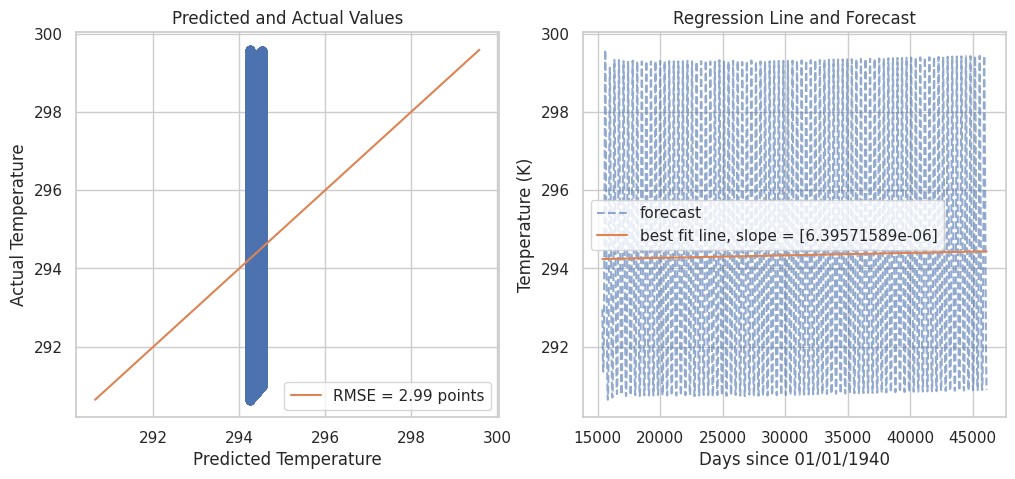

In [139]:
plot_reg(best_alpha_N, X_train_N, y_train_N, forecast_N)

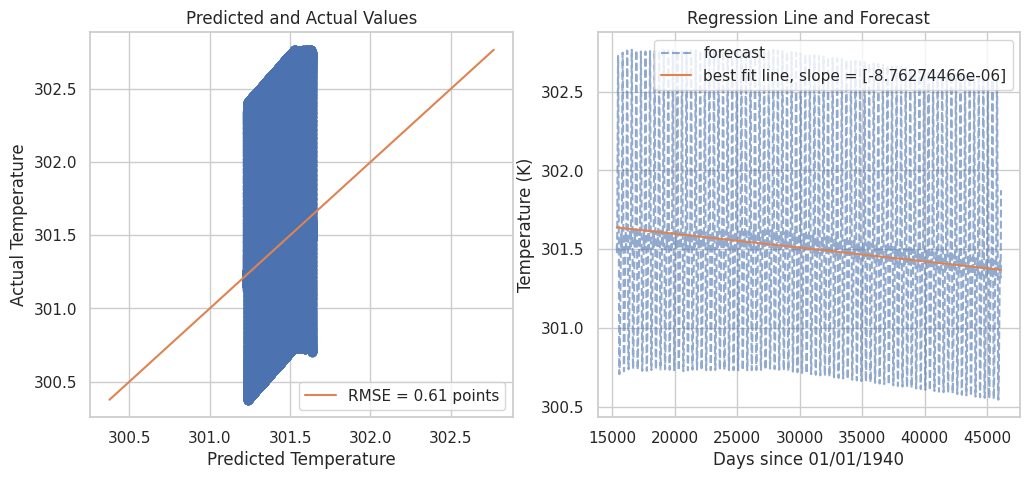

In [140]:
plot_reg(best_alpha_I, X_train_I, y_train_I, forecast_I)

## Conclusion

From spectral analysis, three major fourier components were identified. These three trends have periodicities of 1 year, half a year, and a third of year. Using a 0.001 frequency bandpass filter on these 3 components yields an approximate fourier series that sufficiently approximates the source data.

These filtered series are applied to both oceans and are passed through Meta's prophet model to generate future forecasts for sea surface temperatures. These forecasts are fitted with regression lines so that the overall trend in future sea surface temperatures can be quantified and compared. Based on the prophet model and regression analysis, North Atlantic ocean temperatures will continue to increase with time, but Indian ocean temperatures are starting to decline with time. Thus, this analysis concludes that countries in the North Atlantic area will be suffering more from climate change in the coming years.